In [1]:
from STL_to_path import *
from GPT import *
from NL_to_STL import *
from visualization import *

         Install drake (https://drake.mit.edu/installation.html)
         to use the Drake-based solvers.


In [2]:
T_max = 20              # time horizon in seconds 
dt = 0.5                # time step in seconds
max_acc = 50            # maximum acceleration in m/s^2
max_speed = 0.5         # maximum speed in m/s
N = int(T_max/dt)       # number of time steps
print("N = ", N)

N =  40


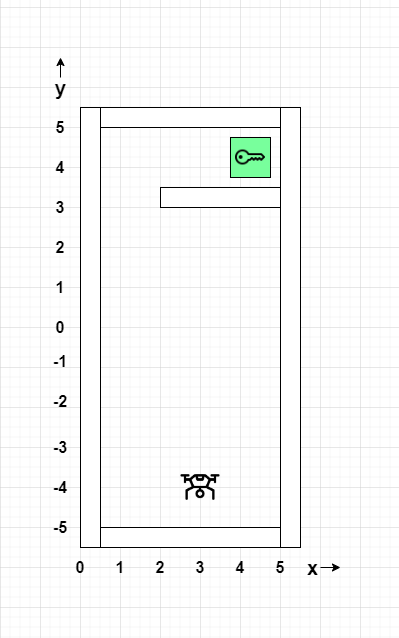

In [3]:
from IPython.display import Image 
image_path = '../../Treasure_hunt_reduced_key.png'                 # path to the image
Image(filename=image_path, width=300, height=200)   # display the image

In [4]:
x0 = np.array([3.,-4.,0.5,0.,0.,0.]) # initial state: x, y, z, vx, vy, vz

objects = {"key": (3.75, 4.75, 3.75, 4.75, 1., 2.),
           "bounds": (0.5, 5., -5., 5., 0., 3.),
           "NE_inside_wall": (2., 5., 3., 3.5, 0., 3.),
           }

In [5]:
# make separate dictionaries for the fixed objects and the interactive objects
fixed_objects = {k: v for k, v in objects.items() if k not in ["key", "bounds"]}
interactive_objects = {k: v for k, v in objects.items() if k in ["key"]}

In [6]:
display("Fixed objects", fixed_objects)
display("Interactive objects", interactive_objects)

'Fixed objects'

{'NE_inside_wall': (2.0, 5.0, 3.0, 3.5, 0.0, 3.0)}

'Interactive objects'

{'key': (3.75, 4.75, 3.75, 4.75, 1.0, 2.0)}

In [7]:
def get_clwh(object):
    # get center, length, width, height of object
    xmin, xmax, ymin, ymax, zmin, zmax = objects[object]
    center = ((xmin + xmax)/2, (ymin + ymax)/2, (zmin + zmax)/2)
    length = xmax - xmin
    width = ymax - ymin
    height = zmax - zmin
    return center, length, width, height

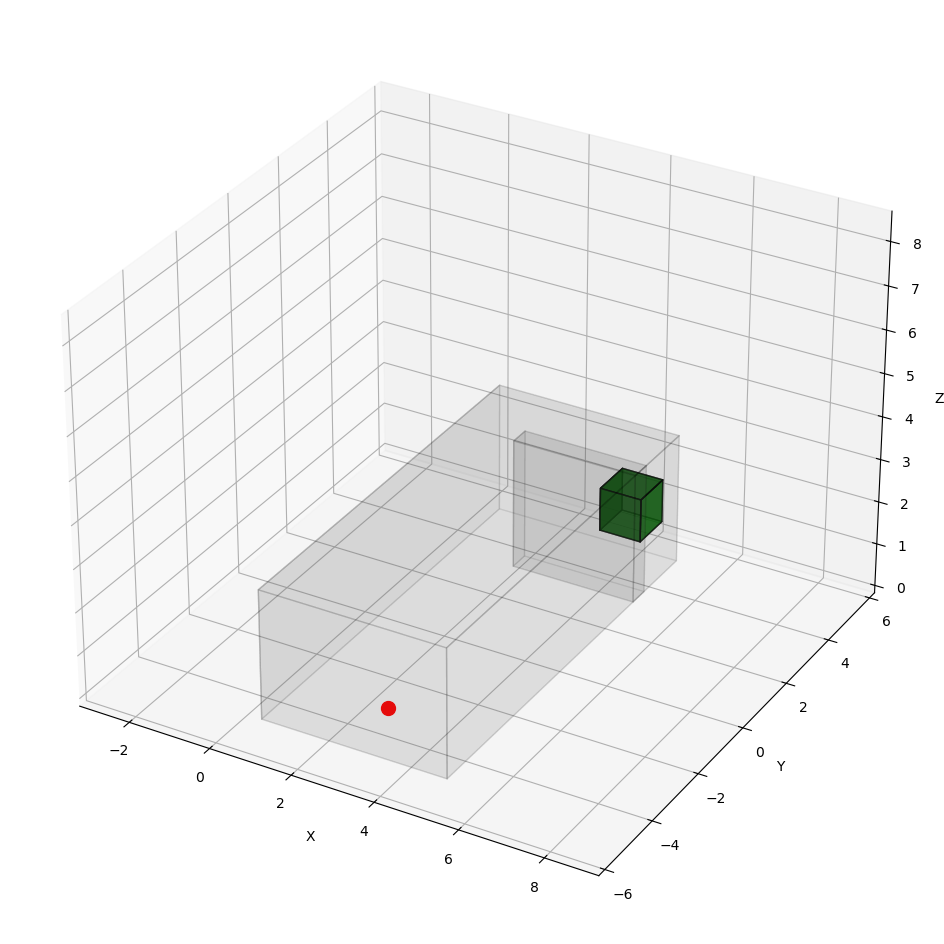

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for object in fixed_objects:
    # omit the ceiling and the floor
    if object in ["ceiling", "floor"]:
        continue
    center, length, width, height = get_clwh(object)
    X, Y, Z = shapes.make_cuboid(center, (length, width, height))
    ax.plot_surface(X, Y, Z, color='gray', rstride=1, cstride=1, alpha=0.05, linewidth=1., edgecolor='k')

# add bounds
center, length, width, height = get_clwh("bounds")
X, Y, Z = shapes.make_cuboid(center, (length, width, height))
ax.plot_surface(X, Y, Z, color='gray', rstride=1, cstride=1, alpha=0.05, linewidth=1., edgecolor='k')

# show key in green, chest in yellow, door in blue
for object in interactive_objects:
    center, length, width, height = get_clwh(object)
    X, Y, Z = shapes.make_cuboid(center, (length, width, height))
    if object == "key":
        ax.plot_surface(X, Y, Z, color='green', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')
    elif object == "chest":
        ax.plot_surface(X, Y, Z, color='yellow', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')
    elif object == "door":
        ax.plot_surface(X, Y, Z, color='blue', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')

# show the initial position of the drone
ax.scatter(x0[0], x0[1], x0[2], color='red', s=100)


ax.set_xlim(-3, 9)
ax.set_ylim(-6, 6)
ax.set_zlim(0, 8.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [9]:
user_input = [{"role": "user", "content": "Get the key."}]
# display the user input only
print(user_input[0]["content"])

Get the key.


In [10]:
translator = NL_to_STL(objects, T_max, dt, print_instructions = True)
spec = translator.extract_STL_formula(user_input)

Instructions:  You are an assistant guiding a drone to perform an instruction specified by a user.
Your task is to take the user's instruction and translate it into a specification in Signal Temporal Logic (STL).
You will be provided with a dictionary of objects in the scene, a list of available python functions, and STL operators that you can use in your generated STL specification.
A time horizon is also provided, which is the maximum time that the solver considers. Do not use a value for time larger than that value. You are allowed to use smaller values.

Objects:
{'key': (3.75, 4.75, 3.75, 4.75, 1.0, 2.0), 'bounds': (0.5, 5.0, -5.0, 5.0, 0.0, 3.0), 'NE_inside_wall': (2.0, 5.0, 3.0, 3.5, 0.0, 3.0)}

Python functions: 
['STL_formulas.inside_cuboid(object)', 'STL_formulas.outside_cuboid(object)', 'STL_formulas.inside_sphere(object)', 'STL_formulas.outside_sphere(object)']

STL operators:
['&', '|']

STL specifications are represented as Python objects. some functions operate on these 

In [11]:
fixed_objects

{'NE_inside_wall': (2.0, 5.0, 3.0, 3.5, 0.0, 3.0)}

In [12]:
#fixed_objects_to_add = []
fixed_objects_to_add = fixed_objects

In [13]:
# add bounds
spec = spec + f' & STL_formulas.inside_cuboid(objects["bounds"]).always(0, {N})'

# append avoid fixed objects
for object in fixed_objects_to_add:
    spec = spec + f' & STL_formulas.outside_cuboid(fixed_objects["{object}"]).always(0, {N})'

In [14]:
print(spec)
spec = eval(spec)
spec

STL_formulas.inside_cuboid(objects["key"]).eventually(0, N) & STL_formulas.inside_cuboid(objects["bounds"]).always(0, 40) & STL_formulas.outside_cuboid(fixed_objects["NE_inside_wall"]).always(0, 40)


In [15]:
solver = STLSolver(spec, x0, T_max)
x,u = solver.generate_trajectory(dt, max_acc, max_speed, verbose=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-29
Setting up optimization problem...
Setup complete in 3.72100567817688 seconds.
<class 'gurobipy.MQuadExpr'>
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3820 rows, 2712 columns and 7994 nonzeros
Model fingerprint: 0x2774620a
Model has 123 quadratic objective terms
Variable types: 1974 continuous, 738 integer (738 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3553 rows and 2433 columns
Presolve time: 0.02s
Presol

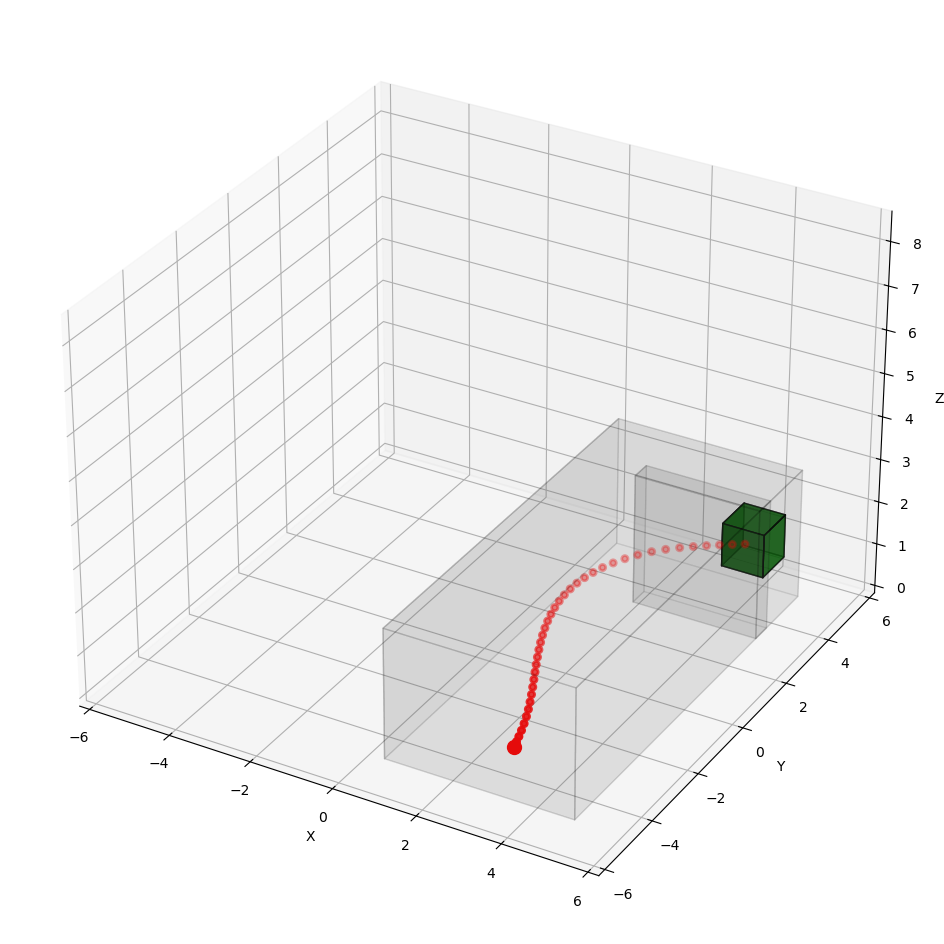

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for object in fixed_objects:
    center, length, width, height = get_clwh(object)
    X, Y, Z = shapes.make_cuboid(center, (length, width, height))
    ax.plot_surface(X, Y, Z, color='gray', rstride=1, cstride=1, alpha=0.05, linewidth=1., edgecolor='k')

# add bounds
center, length, width, height = get_clwh("bounds")
X, Y, Z = shapes.make_cuboid(center, (length, width, height))
ax.plot_surface(X, Y, Z, color='gray', rstride=1, cstride=1, alpha=0.05, linewidth=1., edgecolor='k')

# show key in green, chest in yellow, door in blue
for object in interactive_objects:
    center, length, width, height = get_clwh(object)
    X, Y, Z = shapes.make_cuboid(center, (length, width, height))
    if object == "key":
        ax.plot_surface(X, Y, Z, color='green', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')
    elif object == "chest":
        ax.plot_surface(X, Y, Z, color='yellow', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')
    elif object == "door":
        ax.plot_surface(X, Y, Z, color='blue', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')

# show the initial position of the drone
ax.scatter(x0[0], x0[1], x0[2], color='red', s=100)

# plot the trajectory
ax.scatter(x[0,:], x[1,:], x[2,:], color='red', linewidth=2)


ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(0, 8.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [17]:
# function to check if the drone is inside the cuboid
def inside_cuboid(x, bounds):
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    if x[0] >= xmin and x[0] <= xmax and x[1] >= ymin and x[1] <= ymax and x[2] >= zmin and x[2] <= zmax:
        return True
    else:
        return False

In [18]:
print(inside_cuboid(x0, objects["bounds"]))
print(inside_cuboid(x0, objects["key"]))

True
False


In [19]:
inside_array = np.zeros((N, len(objects)))
for t in range(N):
    for i, object in enumerate(objects):
        inside_array[t, i] = inside_cuboid(x[:,t], objects[object])

In [20]:
inside_array.shape

(40, 3)

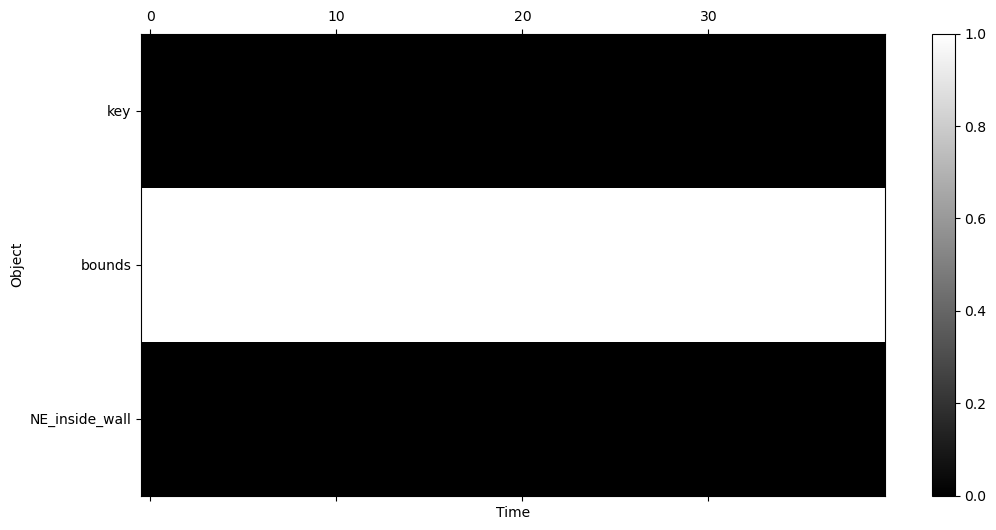

In [21]:
# show at which time the drone is inside the objects
fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.matshow(inside_array.T, aspect='auto', cmap='gray')
ax.set_xlabel('Time')
ax.set_ylabel('Object')
ax.set_yticks(np.arange(len(objects)))
ax.set_yticklabels(objects.keys())
ax.set_xticks(np.arange(0, N, 10))
fig.colorbar(cax)
plt.show()

In [22]:
def make_rectangle_patch(bounds):
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    return plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, edgecolor='k')

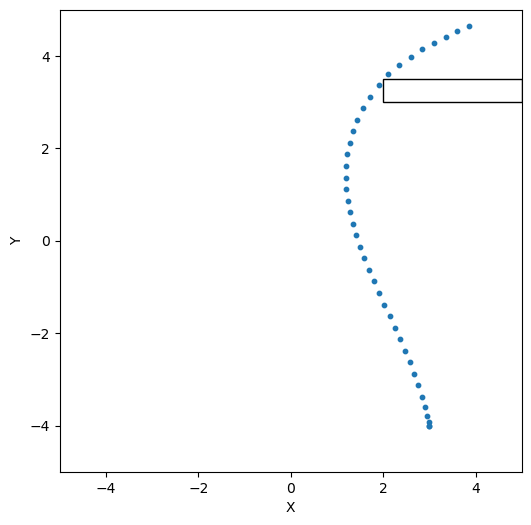

In [23]:
# plot x-y projection
fig, ax = plt.subplots(figsize=(6, 6))
for object in fixed_objects:
    ax.add_patch(make_rectangle_patch(objects[object]))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')
ax.scatter(x[0,:], x[1,:], s=10)

In [24]:
T_max = 20              # time horizon in seconds 
dt = 0.5                # time step in seconds
max_acc = 50            # maximum acceleration in m/s^2
max_speed = 1.         # maximum speed in m/s
N = int(T_max/dt)       # number of time steps
print("N = ", N)

N =  40


In [25]:
# set new x0
x0 = x[:,-1]
x0

array([3.85      , 4.65      , 1.1       , 0.5       , 0.23333333,
       0.04556962])

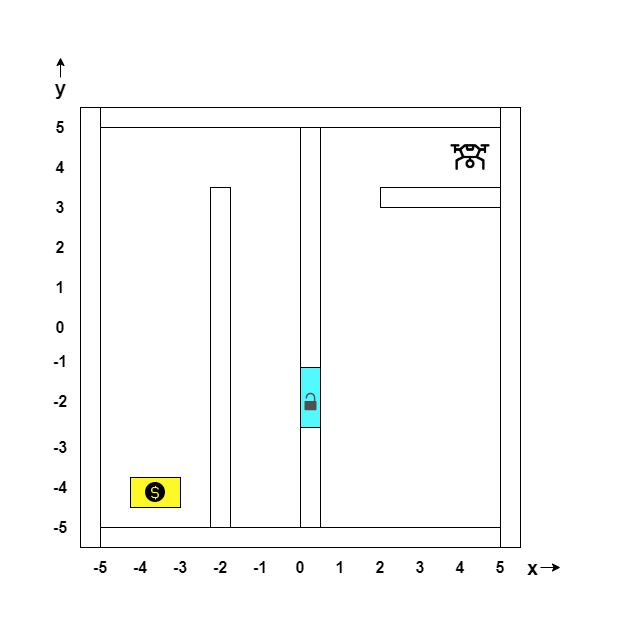

In [26]:
from IPython.display import Image 
image_path = '../../Treasure_hunt_reduced_chest.png'                 # path to the image
Image(filename=image_path, width=400, height=400)   # display the image

In [27]:
objects = {"key" : (3.75, 4.75, 3.75, 4.75, 1., 2.),
           "chest": (-4.25, -3, -4.5, -3.75, 0., 0.75),
           "door": (0., 0.5, -2.5, -1, 0., 2.5),
           "bounds": (-5., 5., -5., 5., 0., 3.),
           "NE_inside_wall": (2., 5., 3., 3.5, 0., 3.),
           "south_mid_inside_wall": (0., 0.5, -5., -2.5, 0., 3.),
           "north_mid_inside_wall": (0., 0.5, -1., 5., 0., 3.),
           "west_inside_wall": (-2.25, -1.75, -5., 3.5, 0., 3.),
           "top_door": (0., 0.5, -2.5, -1, 2.5, 3.),
           }

In [28]:
# make separate dictionaries for the fixed objects and the interactive objects
fixed_objects = {k: v for k, v in objects.items() if k not in ["key", "chest", "door", "bounds"]}
interactive_objects = {k: v for k, v in objects.items() if k in ["key", "chest", "door"]}

In [29]:
display("Fixed objects", fixed_objects)
display("Interactive objects", interactive_objects)

'Fixed objects'

{'NE_inside_wall': (2.0, 5.0, 3.0, 3.5, 0.0, 3.0),
 'south_mid_inside_wall': (0.0, 0.5, -5.0, -2.5, 0.0, 3.0),
 'north_mid_inside_wall': (0.0, 0.5, -1.0, 5.0, 0.0, 3.0),
 'west_inside_wall': (-2.25, -1.75, -5.0, 3.5, 0.0, 3.0),
 'top_door': (0.0, 0.5, -2.5, -1, 2.5, 3.0)}

'Interactive objects'

{'key': (3.75, 4.75, 3.75, 4.75, 1.0, 2.0),
 'chest': (-4.25, -3, -4.5, -3.75, 0.0, 0.75),
 'door': (0.0, 0.5, -2.5, -1, 0.0, 2.5)}

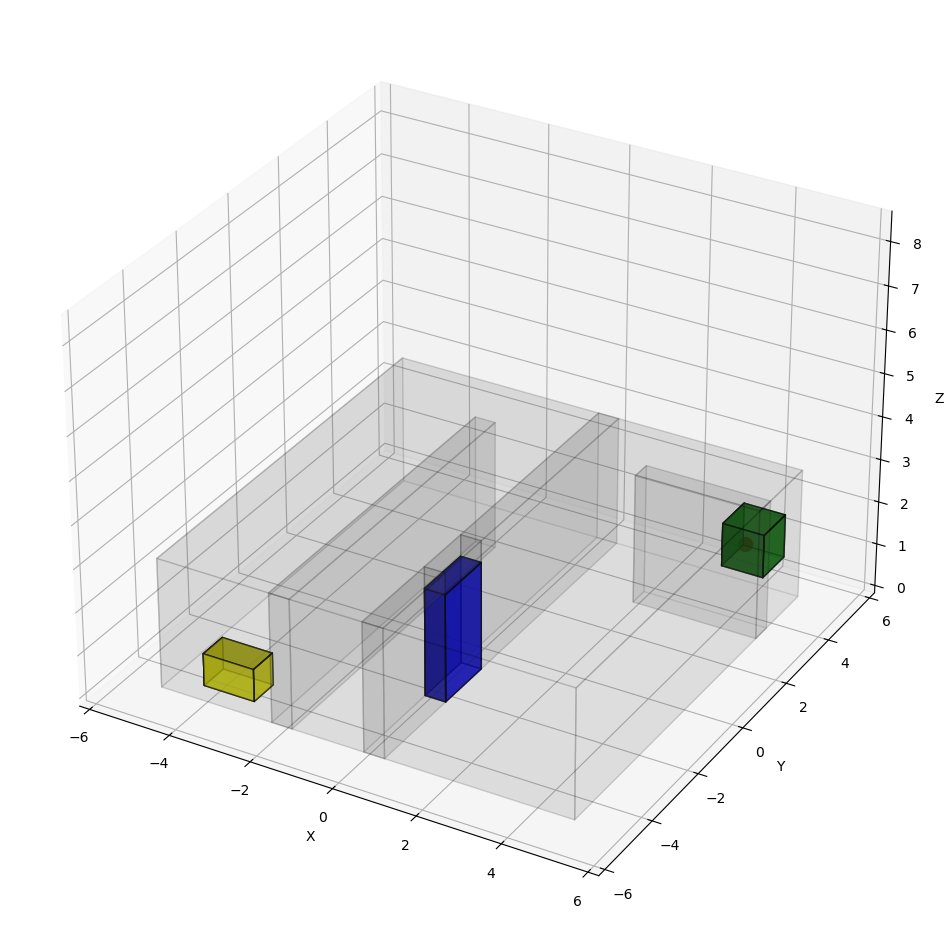

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for object in fixed_objects:
    # omit the ceiling and the floor
    if object in ["ceiling", "floor"]:
        continue
    center, length, width, height = get_clwh(object)
    X, Y, Z = shapes.make_cuboid(center, (length, width, height))
    ax.plot_surface(X, Y, Z, color='gray', rstride=1, cstride=1, alpha=0.05, linewidth=1., edgecolor='k')

# add bounds
center, length, width, height = get_clwh("bounds")
X, Y, Z = shapes.make_cuboid(center, (length, width, height))
ax.plot_surface(X, Y, Z, color='gray', rstride=1, cstride=1, alpha=0.05, linewidth=1., edgecolor='k')

# show key in green, chest in yellow, door in blue
for object in interactive_objects:
    center, length, width, height = get_clwh(object)
    X, Y, Z = shapes.make_cuboid(center, (length, width, height))
    if object == "key":
        ax.plot_surface(X, Y, Z, color='green', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')
    elif object == "chest":
        ax.plot_surface(X, Y, Z, color='yellow', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')
    elif object == "door":
        ax.plot_surface(X, Y, Z, color='blue', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')

# show the initial position of the drone
ax.scatter(x0[0], x0[1], x0[2], color='red', s=100)


ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(0, 8.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [31]:
user_input = [{"role": "user", "content": "Go to the chest."}]
# display the user input only
print(user_input[0]["content"])

Go to the chest.


In [32]:
translator = NL_to_STL(objects, T_max, dt, print_instructions = True)
spec = translator.extract_STL_formula(user_input)

Instructions:  You are an assistant guiding a drone to perform an instruction specified by a user.
Your task is to take the user's instruction and translate it into a specification in Signal Temporal Logic (STL).
You will be provided with a dictionary of objects in the scene, a list of available python functions, and STL operators that you can use in your generated STL specification.
A time horizon is also provided, which is the maximum time that the solver considers. Do not use a value for time larger than that value. You are allowed to use smaller values.

Objects:
{'key': (3.75, 4.75, 3.75, 4.75, 1.0, 2.0), 'chest': (-4.25, -3, -4.5, -3.75, 0.0, 0.75), 'door': (0.0, 0.5, -2.5, -1, 0.0, 2.5), 'bounds': (-5.0, 5.0, -5.0, 5.0, 0.0, 3.0), 'NE_inside_wall': (2.0, 5.0, 3.0, 3.5, 0.0, 3.0), 'south_mid_inside_wall': (0.0, 0.5, -5.0, -2.5, 0.0, 3.0), 'north_mid_inside_wall': (0.0, 0.5, -1.0, 5.0, 0.0, 3.0), 'west_inside_wall': (-2.25, -1.75, -5.0, 3.5, 0.0, 3.0), 'top_door': (0.0, 0.5, -2.5,

In [33]:
fixed_objects

{'NE_inside_wall': (2.0, 5.0, 3.0, 3.5, 0.0, 3.0),
 'south_mid_inside_wall': (0.0, 0.5, -5.0, -2.5, 0.0, 3.0),
 'north_mid_inside_wall': (0.0, 0.5, -1.0, 5.0, 0.0, 3.0),
 'west_inside_wall': (-2.25, -1.75, -5.0, 3.5, 0.0, 3.0),
 'top_door': (0.0, 0.5, -2.5, -1, 2.5, 3.0)}

In [34]:
#fixed_objects_to_add = []
fixed_objects_to_add = fixed_objects

In [35]:
# add bounds
spec = spec + f' & STL_formulas.inside_cuboid(objects["bounds"]).always(0, {N})'

# append avoid fixed objects
for object in fixed_objects_to_add:
    spec = spec + f' & STL_formulas.outside_cuboid(fixed_objects["{object}"]).always(0, {N})'

In [36]:
print(spec)
spec = eval(spec)
spec

STL_formulas.inside_cuboid(objects["chest"]).eventually(0, N) & STL_formulas.inside_cuboid(objects["bounds"]).always(0, 40) & STL_formulas.outside_cuboid(fixed_objects["NE_inside_wall"]).always(0, 40) & STL_formulas.outside_cuboid(fixed_objects["south_mid_inside_wall"]).always(0, 40) & STL_formulas.outside_cuboid(fixed_objects["north_mid_inside_wall"]).always(0, 40) & STL_formulas.outside_cuboid(fixed_objects["west_inside_wall"]).always(0, 40) & STL_formulas.outside_cuboid(fixed_objects["top_door"]).always(0, 40)


In [37]:
solver = STLSolver(spec, x0, T_max)
x_new,u_new = solver.generate_trajectory(dt, max_acc, max_speed, verbose=True)

Setting up optimization problem...
Setup complete in 7.822138071060181 seconds.
<class 'gurobipy.MQuadExpr'>
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6780 rows, 5508 columns and 15718 nonzeros
Model fingerprint: 0x5d740696
Model has 123 quadratic objective terms
Variable types: 3786 continuous, 1722 integer (1722 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 6509 rows and 5236 columns
Presolve time: 0.04s
Presolved: 271 rows, 272 columns, 850 nonzeros
Presolved model has 120 quadratic objective te

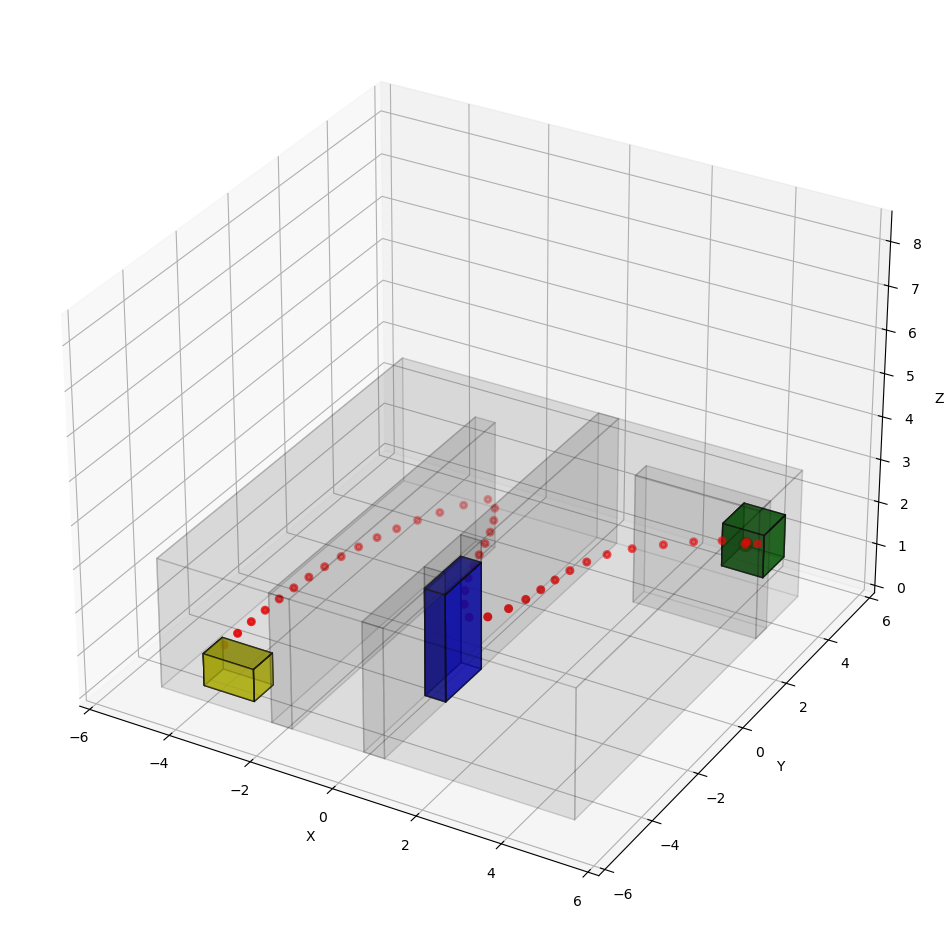

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for object in fixed_objects:
    center, length, width, height = get_clwh(object)
    X, Y, Z = shapes.make_cuboid(center, (length, width, height))
    ax.plot_surface(X, Y, Z, color='gray', rstride=1, cstride=1, alpha=0.05, linewidth=1., edgecolor='k')

# add bounds
center, length, width, height = get_clwh("bounds")
X, Y, Z = shapes.make_cuboid(center, (length, width, height))
ax.plot_surface(X, Y, Z, color='gray', rstride=1, cstride=1, alpha=0.05, linewidth=1., edgecolor='k')

# show key in green, chest in yellow, door in blue
for object in interactive_objects:
    center, length, width, height = get_clwh(object)
    X, Y, Z = shapes.make_cuboid(center, (length, width, height))
    if object == "key":
        ax.plot_surface(X, Y, Z, color='green', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')
    elif object == "chest":
        ax.plot_surface(X, Y, Z, color='yellow', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')
    elif object == "door":
        ax.plot_surface(X, Y, Z, color='blue', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')

# show the initial position of the drone
ax.scatter(x0[0], x0[1], x0[2], color='red', s=100)

# plot the trajectory
ax.scatter(x_new[0,:], x_new[1,:], x_new[2,:], color='red', linewidth=2)


ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(0, 8.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [39]:
inside_array = np.zeros((N, len(objects)))
for t in range(N):
    for i, object in enumerate(objects):
        inside_array[t, i] = inside_cuboid(x_new[:,t], objects[object])

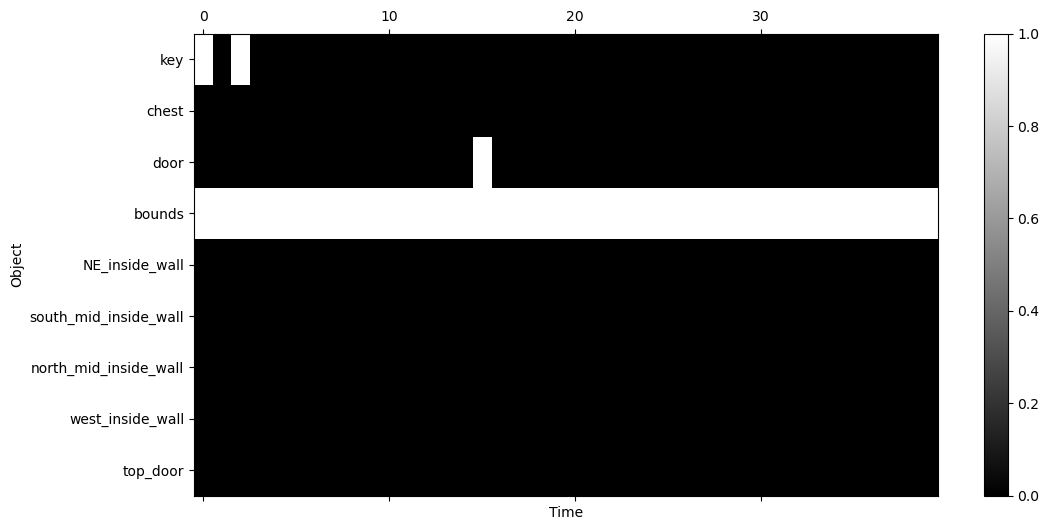

In [40]:
# show at which time the drone is inside the objects
fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.matshow(inside_array.T, aspect='auto', cmap='gray')
ax.set_xlabel('Time')
ax.set_ylabel('Object')
ax.set_yticks(np.arange(len(objects)))
ax.set_yticklabels(objects.keys())
ax.set_xticks(np.arange(0, N+1, 10))
fig.colorbar(cax)
plt.show()

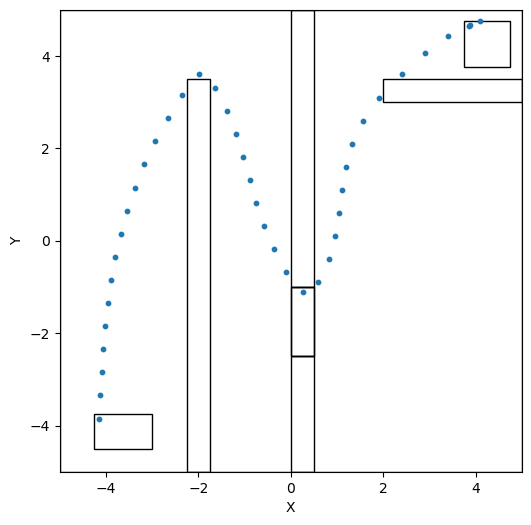

In [41]:
# plot x-y projection
fig, ax = plt.subplots(figsize=(6, 6))
for object in objects:
    ax.add_patch(make_rectangle_patch(objects[object]))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')
ax.scatter(x_new[0,:], x_new[1,:], s=10)

In [43]:
# full path
x_full = np.hstack((x, x_new[:,1:]))
print(x_full.shape)


(6, 81)


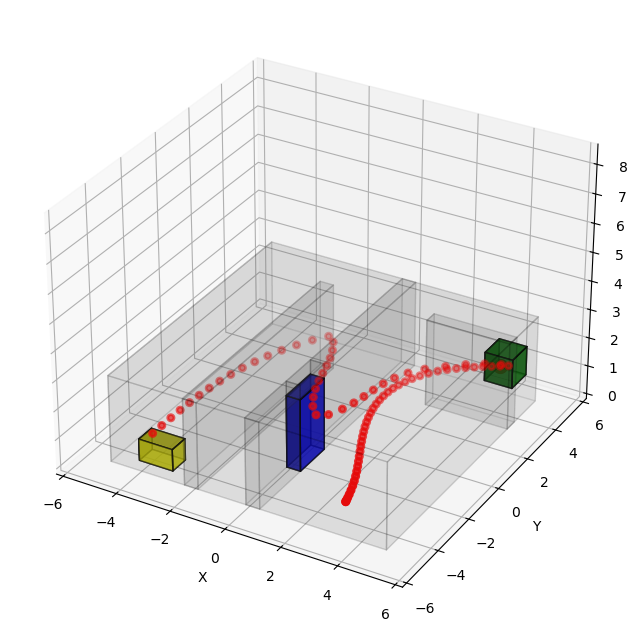

In [45]:
# visualize the full path
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

for object in fixed_objects:
    center, length, width, height = get_clwh(object)
    X, Y, Z = shapes.make_cuboid(center, (length, width, height))
    ax.plot_surface(X, Y, Z, color='gray', rstride=1, cstride=1, alpha=0.05, linewidth=1., edgecolor='k')

# add bounds
center, length, width, height = get_clwh("bounds")
X, Y, Z = shapes.make_cuboid(center, (length, width, height))
ax.plot_surface(X, Y, Z, color='gray', rstride=1, cstride=1, alpha=0.05, linewidth=1., edgecolor='k')

# show key in green, chest in yellow, door in blue
for object in interactive_objects:
    center, length, width, height = get_clwh(object)
    X, Y, Z = shapes.make_cuboid(center, (length, width, height))
    if object == "key":
        ax.plot_surface(X, Y, Z, color='green', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')
    elif object == "chest":
        ax.plot_surface(X, Y, Z, color='yellow', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')
    elif object == "door":
        ax.plot_surface(X, Y, Z, color='blue', rstride=1, cstride=1, alpha=0.5, linewidth=1., edgecolor='k')

# show the initial position of the drone
ax.scatter(x0[0], x0[1], x0[2], color='red', s=100)

# plot the trajectory
ax.scatter(x_full[0,:], x_full[1,:], x_full[2,:], color='red', linewidth=2)


ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(0, 8.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

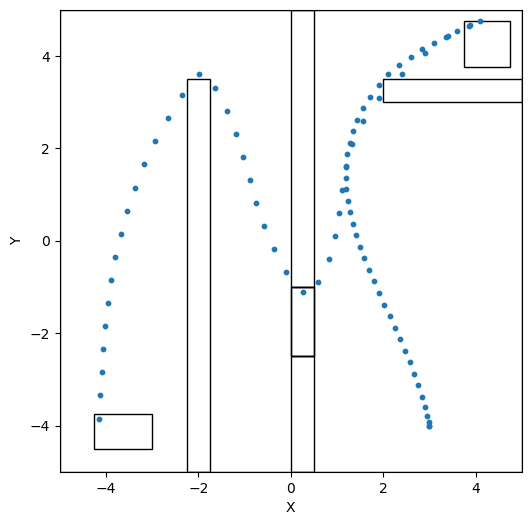

In [46]:
# plot x-y projection
fig, ax = plt.subplots(figsize=(6, 6))
for object in objects:
    ax.add_patch(make_rectangle_patch(objects[object]))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')
ax.scatter(x_full[0,:], x_full[1,:], s=10)

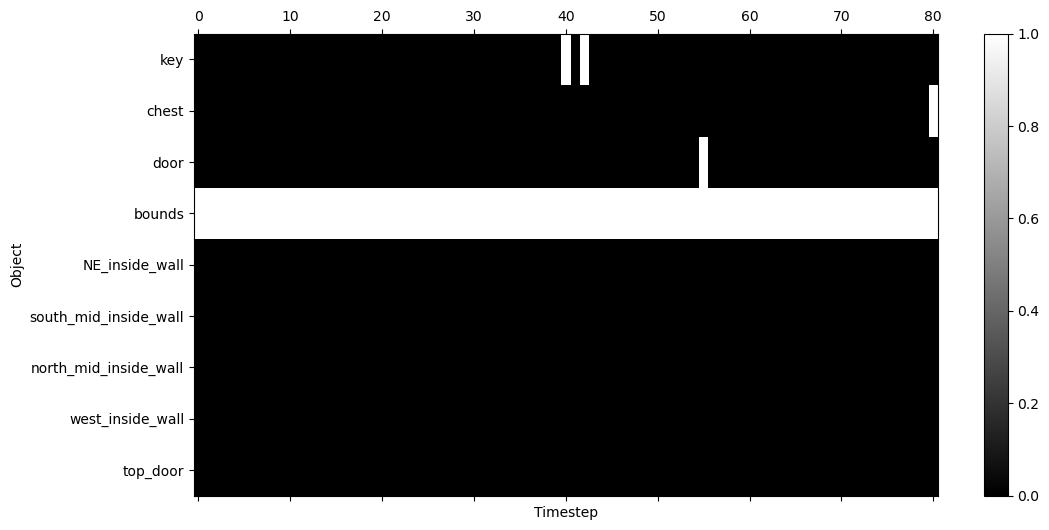

In [51]:
inside_array = np.zeros((2*N+1, len(objects)))
for t in range(2*N+1):
    for i, object in enumerate(objects):
        inside_array[t, i] = inside_cuboid(x_full[:,t], objects[object])

# show at which time the drone is inside the objects
fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.matshow(inside_array.T, aspect='auto', cmap='gray')
ax.set_xlabel('Timestep')
ax.set_ylabel('Object')
ax.set_yticks(np.arange(len(objects)))
ax.set_yticklabels(objects.keys())
ax.set_xticks(np.arange(0, 2*N+1, 10))
fig.colorbar(cax)
plt.show()